In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Wine Data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

wine_data = pd.read_csv(url, sep=';')

wine_data_normalize = wine_data.copy()
wine_data_normalize = wine_data_normalize[wine_data_normalize['total sulfur dioxide']<200]

col_zscore = wine_data_normalize.keys()
col_zscore = col_zscore.drop("quality")
wine_data_normalize[col_zscore] = wine_data_normalize[col_zscore].apply(stats.zscore)

wine_data_normalize["boolQuantity"] = 0
wine_data_normalize["boolQuantity"][wine_data_normalize["quality"]>5] = 1


C:\Users\drkum\AppData\Local\Temp\ipykernel_16792\3828624143.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_data_normalize["boolQuantity"][wine_data_normalize["quality"]>5] = 1


In [3]:
data_tensor = torch.tensor(wine_data_normalize[col_zscore].values).float()
label_tensor = torch.tensor(data=wine_data_normalize["boolQuantity"].values).float()
label_tensor = label_tensor[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, label_tensor, test_size=0.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, shuffle=True, drop_last=True, batch_size=32)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
class wineClass(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11, 16)
        
        self.hidden_1 = nn.Linear(16, 32)
        self.batch_norm_1 = nn.BatchNorm1d(16)
        self.hidden_2 = nn.Linear(32, 20)
        self.batch_norm_2 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(20, 1)
        
    def forward(self, x, batch_norm):
        
        x = self.input(x)
        x = F.relu(x)
        
        if batch_norm:
            x = self.batch_norm_1(x)
            x = self.hidden_1(x)
            x = F.relu(x)
            
            x = self.batch_norm_2(x)
            x = self.hidden_2(x)
            x = F.relu(x)
        else:
            x = self.hidden_1(x)
            x = F.relu(x)

            x = self.hidden_2(x)
            x = F.relu(x)
        
        return self.output(x)

In [5]:
num_epochs = 1500

def trainModel(annWine, batch_norm):
    
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(annWine.parameters(), lr=0.01)
    
    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        annWine.train()
        
        batch_acc = []
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = annWine(x, batch_norm)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_acc.append(100*torch.mean(((y_hat > 0) == y).float()).item())
        
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        annWine.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean(((annWine(x, batch_norm) > 0) == y).float()).item())
    
    return train_acc, test_acc, losses

In [6]:
annWine = wineClass()
train_acc_withBatch, test_acc_withBatch, losses_withBatch = trainModel(annWine, True)

annWine = wineClass()
train_acc_noBatch, test_acc_noBatch, losses_noBatch = trainModel(annWine, False)

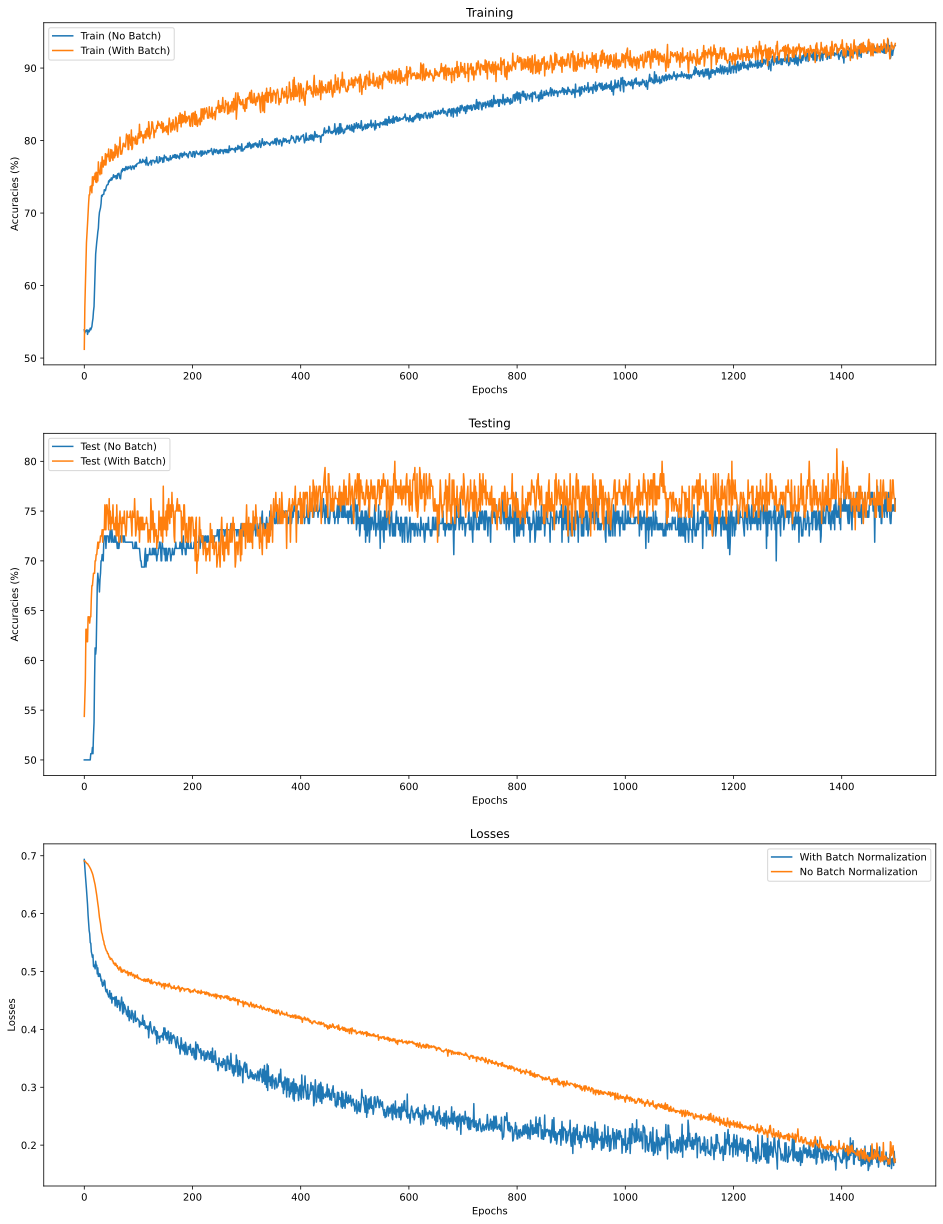

In [7]:
_, axis = plt.subplots(3, 1, figsize=(16, 21))

axis[0].plot(train_acc_noBatch)
axis[0].plot(train_acc_withBatch)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_title("Training")
axis[0].legend(["Train (No Batch)", "Train (With Batch)"])

axis[1].plot(test_acc_noBatch)
axis[1].plot(test_acc_withBatch)
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_title("Testing")
axis[1].legend(["Test (No Batch)", "Test (With Batch)"])

axis[2].plot(losses_withBatch)
axis[2].plot(losses_noBatch)
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Losses")
axis[2].set_title("Losses")
axis[2].legend(["With Batch Normalization", "No Batch Normalization"]);

# Two Armies Classification

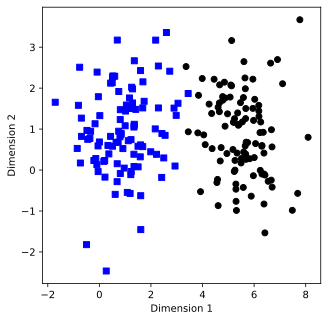

In [8]:
nPerClust = 100

A = [1, 1]
B = [5.5, 1]
np.random.seed(15)
a = [A[0]+np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
b = [B[0]+np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
data_np = np.hstack((a,b)).T

data_tensor = torch.tensor(data_np).float()
label_tensor = torch.tensor(labels_np).float()

plt.figure(figsize=(5,5))
plt.plot(data_tensor[np.where(label_tensor==0)[0],0],data_tensor[np.where(label_tensor==0)[0],1],'bs')
plt.plot(data_tensor[np.where(label_tensor==1)[0],0],data_tensor[np.where(label_tensor==1)[0],1],'ko')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2');

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, label_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, shuffle=True, drop_last=True, batch_size=16)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [10]:
class twoArmyClass(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 6)

        self.hidden_1 = nn.Linear(6, 4)
        self.batch_norm_1 = nn.BatchNorm1d(6)

        self.output = nn.Linear(4, 1)

    def forward(self, x, batch_norm):

        x = self.input(x)
        x = F.relu(x)

        if batch_norm:
            x = self.batch_norm_1(x)
            x = self.hidden_1(x)
            x = F.relu(x)
        else:
            x = self.hidden_1(x)
            x = F.relu(x)

        return self.output(x)

In [11]:
num_epochs = 500

def trainModel(annArmy, batch_norm):

    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(annArmy.parameters(), lr=0.003)

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annArmy.train()

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = annArmy(x, batch_norm)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)

        annArmy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean(((annArmy(x, batch_norm) > 0.5) == y).float()).item())

    predictions = annArmy(data_tensor, batch_norm)
    predict_labels = predictions>.5

    misclassified = np.where(predict_labels != label_tensor)[0]

    total_acc = 100-100*len(misclassified)/(2*nPerClust)
    print('Final accuracy: %g%%' %total_acc)

    return train_acc, test_acc, losses, misclassified, predict_labels

In [12]:
annArmy = twoArmyClass()
train_acc_withBatch, test_acc_withBatch, losses_withBatch, misclassified_withBatch, predict_labels_withBatch = trainModel(annArmy, True)

annArmy = twoArmyClass()
train_acc_noBatch, test_acc_noBatch, losses_noBatch, misclassified_noBatch, predict_labels_noBatch = trainModel(annArmy, False)

Final accuracy: 99%
Final accuracy: 96%


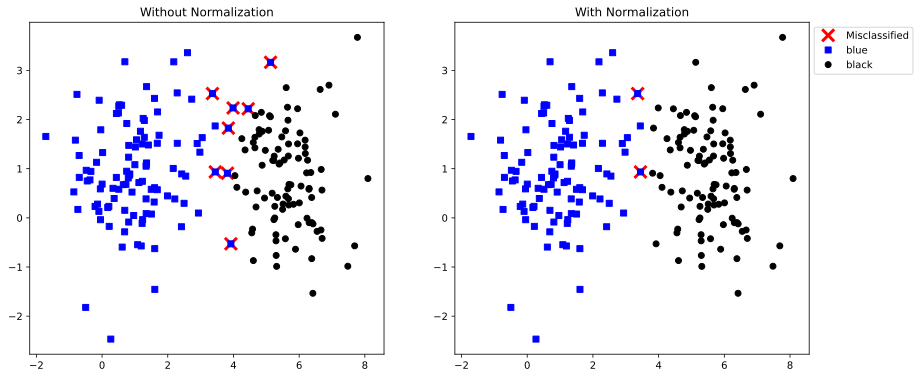

In [13]:
_, axis = plt.subplots(1, 2, figsize=(14, 6))
axis[0].plot(data_tensor[misclassified_noBatch,0] ,data_tensor[misclassified_noBatch,1],'rx',markersize=12,markeredgewidth=3)
axis[0].plot(data_tensor[np.where(~predict_labels_noBatch)[0],0],data_tensor[np.where(~predict_labels_noBatch)[0],1],'bs')
axis[0].plot(data_tensor[np.where(predict_labels_noBatch)[0],0] ,data_tensor[np.where(predict_labels_noBatch)[0],1] ,'ko')
axis[0].set_title("Without Normalization")

axis[1].plot(data_tensor[misclassified_withBatch,0] ,data_tensor[misclassified_withBatch,1],'rx',markersize=12,markeredgewidth=3)
axis[1].plot(data_tensor[np.where(~predict_labels_withBatch)[0],0],data_tensor[np.where(~predict_labels_withBatch)[0],1],'bs')
axis[1].plot(data_tensor[np.where(predict_labels_withBatch)[0],0] ,data_tensor[np.where(predict_labels_withBatch)[0],1] ,'ko')
axis[1].set_title("With Normalization")
plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1));

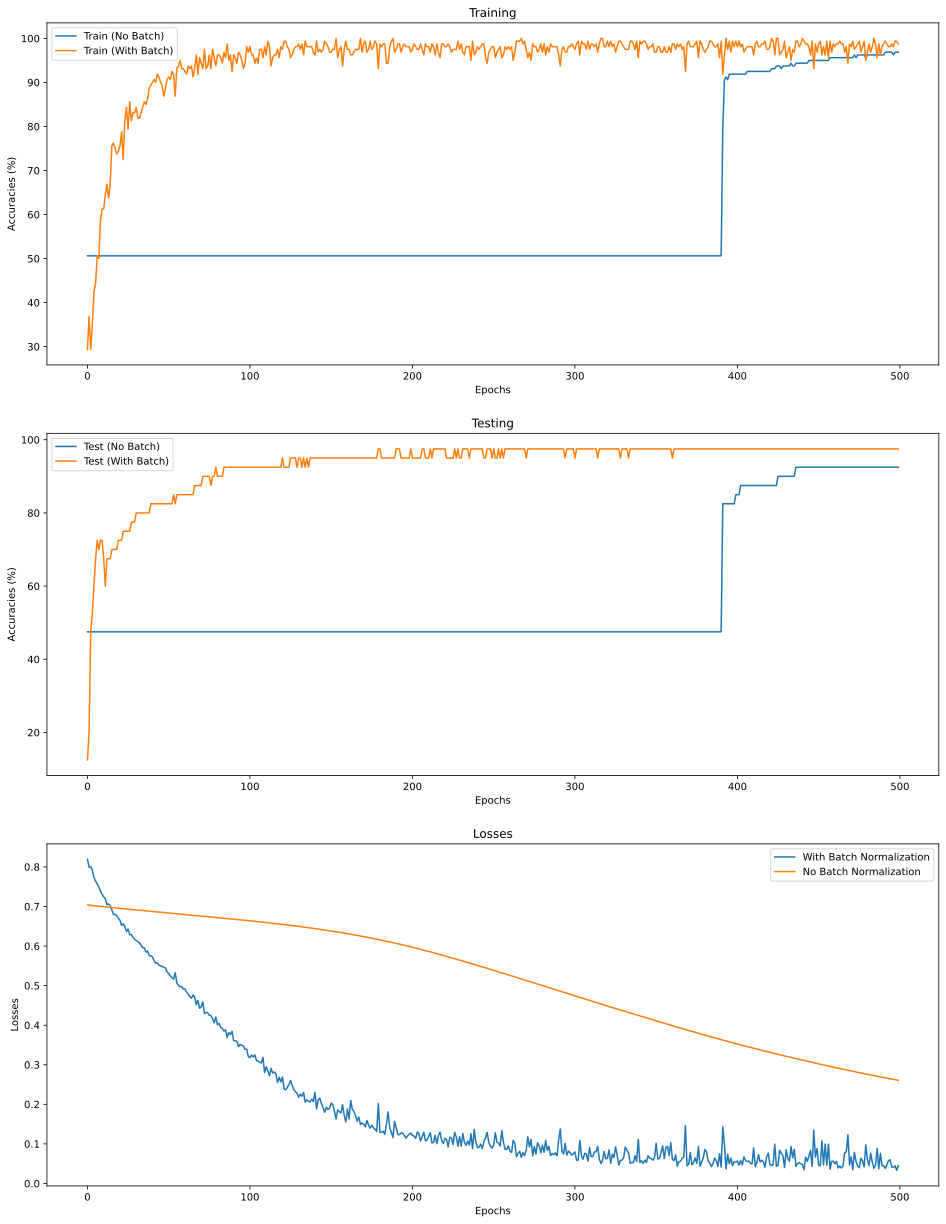

In [14]:
_, axis = plt.subplots(3, 1, figsize=(16, 21))

axis[0].plot(train_acc_noBatch)
axis[0].plot(train_acc_withBatch)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_title("Training")
axis[0].legend(["Train (No Batch)", "Train (With Batch)"])

axis[1].plot(test_acc_noBatch)
axis[1].plot(test_acc_withBatch)
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_title("Testing")
axis[1].legend(["Test (No Batch)", "Test (With Batch)"])

axis[2].plot(losses_withBatch)
axis[2].plot(losses_noBatch)
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Losses")
axis[2].set_title("Losses")
axis[2].legend(["With Batch Normalization", "No Batch Normalization"]);